# Batch methods on the bilinear example



In [ ]:
# install latex for plots description
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt-get install texlive-full

In [3]:
# -*- coding: utf-8 -*-
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
from pylab import rcParams
import torch
from copy import deepcopy as dcp
var2np = lambda x: x.detach().cpu().numpy()

plt.rcParams['text.latex.preamble'] = [r"\usepackage{lmodern}"]
rcParams['figure.figsize'] = 8.5, 6
rcParams['text.usetex'] = True
rcParams['figure.dpi'] = 190
rcParams['font.family'] = 'lmodern'
rcParams['font.size'] = '15'
rcParams['text.latex.unicode'] = True

# Set random seed
np.random.seed(3)
# Initialize the parameters
d = 10 ** 2
n = d
n_iter = 10 ** 2
n_runs = 5
# Initialize the variables
x_0, y_0 = [], []
for _ in range(n_runs):
    x_d = int(np.random.randint(d**2, size=1)) + 1
    y_d = int(np.random.randint(d**2, size=1)) + 1
    x_0.append(1. / np.sqrt(x_d) * np.random.randn(d))
    y_0.append(1. / np.sqrt(y_d) * np.random.randn(d))

# Initialize the constants
M = np.zeros((n, d, d))
for i in range(d):
    M[i] = np.zeros((d, d))
    M[i][i, i] = 1
M_mean = np.mean(M, 0)

list_a, list_b = [], []
list_x_star, list_y_star = [], []
for _ in range(n_runs):
    b = np.zeros((n, d))
    a = np.zeros((n, d))

    # Simple bilinear objective.
    for i in range(d):
        x_d = int(np.random.randint(d**2, size=1)) + 1
        y_d = int(np.random.randint(d**2, size=1)) + 1
        a[i, :] = 1. / np.sqrt(x_d) * np.random.randn(d)
        b[i, :] = 1. / np.sqrt(y_d) * np.random.randn(d)

    # Compute the solution
    a_mean = np.mean(a, 0)
    b_mean = np.mean(b, 0)
    y_star = np.linalg.solve(M_mean, -a_mean)
    x_star = np.linalg.solve(M_mean.T, -b_mean)

    # append
    list_a.append(a)
    list_b.append(b)
    list_x_star.append(x_star)
    list_y_star.append(y_star)


# RGB colors.
colors20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Scale the RGB values to the [0, 1] range.
for i in range(len(colors20)):
    red, green, blue = colors20[i]
    colors20[i] = (red / 255., green / 255., blue / 255.)


def proj(x):
    return x


def batch_update(x, y, M, a, b):
    n = a.shape[0]
    x_grads = np.zeros((a.shape[1]))
    y_grads = np.zeros((a.shape[1]))
    for i in range(n):
        x_grads = x_grads + M[i].dot(y) + a[i]
        y_grads = y_grads + M[i].T.dot(x) + b[i]
    return x_grads, y_grads


def av_std(l):
    av = np.mean(l, 0)
    std = np.std(l, 0) / 2.
    return av, av + std, av - std


def batch_unroll(n_pass, x_0, y_0, n_runs=5, gamma=.1, restart=None, k=5,
            x_unroll=True, y_unroll=True):
    """ Unroll batch gradient.
    k: number of steps to unroll both G and D.
    """
    n = M.shape[0]
    kk = 2 if (x_unroll is True and y_unroll is True) else 1
    l_dist = np.zeros((n_runs, n_pass // (k * kk + 2)))
    l_dist_avg = np.zeros((n_runs, n_pass // (k * kk + 2)))

    for n_run in range(n_runs):
        x_grad = x_0[n_run].copy()
        y_grad = y_0[n_run].copy()
        x_grad_av = x_0[n_run].copy()
        y_grad_av = y_0[n_run].copy()
        a = list_a[n_run]
        b = list_b[n_run]
        x_star = list_x_star[n_run]
        y_star = list_y_star[n_run]

        S_t = 1
        norm_grad = np.linalg.norm(x_grad_av / S_t - x_star) + \
                    np.linalg.norm(y_grad_av / S_t - y_star)
        l_dist[n_run][0] = norm_grad
        l_dist_avg[n_run][0] = norm_grad
        for t in range(int(n_pass // (k * kk + 2)) - 1):
            if restart is not None:
                if np.random.binomial(1, 1. / n * restart):
                    x_grad = x_grad_av.copy() / S_t
                    y_grad = y_grad_av.copy() / S_t
                    S_t = 1
                    x_grad_av = x_grad.copy()
                    y_grad_av = y_grad.copy()
            # Copy params
            x_w = x_grad.copy()
            y_w = y_grad.copy()
            for _ in range(k):  # update x_w, y_w
                if x_unroll:
                    x_w_grads, _ = batch_update(x_w, y_grad, M, a, b)  # L(x_w, y)
                    x_w = proj(x_w - gamma * x_w_grads)
                if y_unroll:
                    _, y_w_grads = batch_update(x_grad, y_w, M, a, b)  # L(x, y_w)
                    y_w = proj(y_w + gamma * y_w_grads)

            xx_grads, _ = batch_update(x_grad, y_w, M, a, b)  # L(x, y_w)
            _, yy_grads = batch_update(x_w, y_grad, M, a, b)  # L(x_w, y)
            x_grad = proj(x_grad - gamma * xx_grads)
            y_grad = proj(y_grad + gamma * yy_grads)

            x_grad_av += x_grad
            y_grad_av += y_grad
            S_t += 1
            # Storing the  distance to the optimum
            l_dist[n_run][t + 1] = np.linalg.norm(x_grad - x_star) + \
                                   np.linalg.norm(y_grad - y_star)
            l_dist_avg[n_run][t + 1] = np.linalg.norm(x_grad_av / S_t - x_star) + \
                                       np.linalg.norm(y_grad_av / S_t - y_star)
    return l_dist, l_dist_avg


def batch_extra(n_pass, x_0, y_0, n_runs=5, gamma=.1, restart=None, extra=True):
    l_dist = np.zeros((n_runs, n_pass // 3 if extra else n_pass))
    l_dist_avg = np.zeros((n_runs, n_pass // 3 if extra else n_pass))

    for n_run in range(n_runs):
        x_grad = x_0[n_run].copy()
        y_grad = y_0[n_run].copy()
        x_avg = x_0[n_run].copy()
        y_avg = y_0[n_run].copy()
        a = list_a[n_run]
        b = list_b[n_run]
        x_star = list_x_star[n_run]
        y_star = list_y_star[n_run]

        S_t = 1
        norm_grad = np.linalg.norm(x_avg / S_t - x_star) + np.linalg.norm(y_avg / S_t - y_star)
        l_dist[n_run][0] = norm_grad
        l_dist_avg[n_run][0] = norm_grad
        for t in range((n_pass // 3 if extra else n_pass) - 1):
            if np.random.binomial(1, 1. / n):
                if restart is not None:
                    if np.random.binomial(1, restart):
                        x_grad = x_avg.copy() / S_t
                        y_grad = y_avg.copy() / S_t
                        S_t = 1
                        x_avg = x_grad.copy()
                        y_avg = y_grad.copy()

            d_x, d_y = batch_update(x_grad, y_grad, M, a, b)
            if extra:
                x_extra = proj(x_grad - gamma * d_x)
                y_extra = proj(y_grad + gamma * d_y)
                d_x, _ = batch_update(x_grad, y_extra, M, a, b)
                _, d_y = batch_update(x_extra, y_grad, M, a, b)
            x_grad = proj(x_grad - gamma * d_x)
            y_grad = proj(y_grad + gamma * d_y)

            # update metrics and avg-params
            x_avg += x_grad
            y_avg += y_grad
            S_t += 1
            l_dist[n_run][t + 1] = np.linalg.norm(x_grad - x_star) + \
                                   np.linalg.norm(y_grad - y_star)
            l_dist_avg[n_run][t + 1] = np.linalg.norm(x_avg / S_t - x_star) + \
                                       np.linalg.norm(y_avg / S_t - y_star)
    return l_dist, l_dist_avg


def batch_lookahead(n_pass, x_0, y_0, n_runs, gamma=.1, restart=None, extra=True,
                    k=5, beta=.5):
    n = M.shape[0]
    l_dist = np.zeros((n_runs, n_pass // 3 if extra else n_pass))
    l_dist_avg = np.zeros((n_runs, n_pass // 3 if extra else n_pass))

    for n_run in range(n_runs):
        x_grad = x_0[n_run].copy()
        y_grad = y_0[n_run].copy()
        x_avg = x_0[n_run].copy()
        y_avg = y_0[n_run].copy()

        x_prev = x_grad.copy()
        y_prev = y_grad.copy()

        a = list_a[n_run]
        b = list_b[n_run]
        x_star = list_x_star[n_run]
        y_star = list_y_star[n_run]

        S_t = 1
        l_dist[n_run][0] = np.linalg.norm(x_grad - x_star) + \
                           np.linalg.norm(y_grad - y_star)
        l_dist_avg[n_run][0] = np.linalg.norm(x_avg / S_t - x_star) + \
                               np.linalg.norm(y_avg / S_t - y_star)
        for t in range((n_pass // 3 if extra else n_pass) - 1):
            if np.random.binomial(1, 1. / n):
                if restart is not None:
                    if np.random.binomial(1, restart):
                        x_grad = x_avg.copy() / S_t
                        y_grad = y_avg.copy() / S_t
                        S_t = 1
                        x_avg = x_grad.copy()
                        y_avg = y_grad.copy()

            if t > 0 and t % k == 0:  # one step backward every 5 steps forward
                x_grad = x_prev + beta * (x_grad - x_prev)
                y_grad = y_prev + beta * (y_grad - y_prev)
                x_prev = x_grad.copy()
                y_prev = y_grad.copy()

            d_x, d_y = batch_update(x_grad, y_grad, M, a, b)
            if extra:
                x_extra = proj(x_grad - gamma * d_x)
                y_extra = proj(y_grad + gamma * d_y)
                d_x, _ = batch_update(x_grad, y_extra, M, a, b)
                _, d_y = batch_update(x_extra, y_grad, M, a, b)
            x_grad = proj(x_grad - gamma * d_x)
            y_grad = proj(y_grad + gamma * d_y)

            # update metrics and avg-params
            x_avg += x_grad
            y_avg += y_grad
            S_t += 1

            l_dist[n_run][t+1] = np.linalg.norm(x_grad - x_star) + \
                                 np.linalg.norm(y_grad - y_star)
            l_dist_avg[n_run][t+1] = np.linalg.norm(x_avg / S_t - x_star) + \
                                     np.linalg.norm(y_avg / S_t - y_star)
    return l_dist, l_dist_avg


# -----------------------------------------------------------------------------
n_pass = 800
gamma = .3  # learning rate, default .3
restart = None  # None | float in [0,1]
ur_k = 6  # for unroll gan
la_k = ur_k
ur_k = ur_k
la_beta = .4  # weight of future iterate point for lin combination with past/stored
la_beta2 = .8 

_info = 'Learning rate {}; {} restart'.format(gamma, 'with' if restart else 'no')
print(_info)
_info = 'step-size:{}; k:{}; n_runs:{}'.format(gamma, ur_k, n_runs)

extra_gd, extra_gd_avg = batch_extra(n_pass, x_0, y_0, n_runs,
                                     gamma=gamma, restart=restart, extra=True)
batch_gd, batch_gd_avg = batch_extra(n_pass, x_0, y_0, n_runs,
                                     gamma=gamma, restart=restart, extra=False)
bgd_small_eta, bgd_small_eta_avg = batch_extra(n_pass, x_0, y_0, n_runs,
                      gamma=1e-4, restart=restart, extra=False)


ur_xy, ur_xy_avg = batch_unroll(n_pass, x_0, y_0, n_runs, gamma=gamma, k=ur_k, restart=None,
                                x_unroll=True, y_unroll=True)
ur_y, ur_y_avg = batch_unroll(n_pass, x_0, y_0, n_runs, gamma=gamma, k=ur_k, restart=restart,
                              x_unroll=False, y_unroll=True)

la_gd, la_gd_avg = batch_lookahead(n_pass, x_0, y_0, n_runs, gamma=gamma,
                                   restart=restart, extra=False, k=la_k)

laB_gd, laB_gd_avg = batch_lookahead(n_pass, x_0, y_0, n_runs, gamma=gamma,
                                     restart=restart, extra=False, k=la_k, 
                                     beta=la_beta)

laB_larger, laB_larger_avg = batch_lookahead(n_pass, x_0, y_0, n_runs, gamma=gamma,
                                     restart=restart, extra=False, k=la_k, 
                                     beta=la_beta2)

la_ex, la_ex_avg = batch_lookahead(n_pass, x_0, y_0, n_runs, gamma=gamma,
                                   restart=restart, extra=True, k=la_k)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


Learning rate 0.3; no restart


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


(0.0, 800.0)

(5e-08, 10000.0)

Text(0.5, 0, 'Number of passes')

Text(0, 0.5, 'Distance to the optimum')

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


Figure bilinear_obj_lr0.3_batch.pdf saved


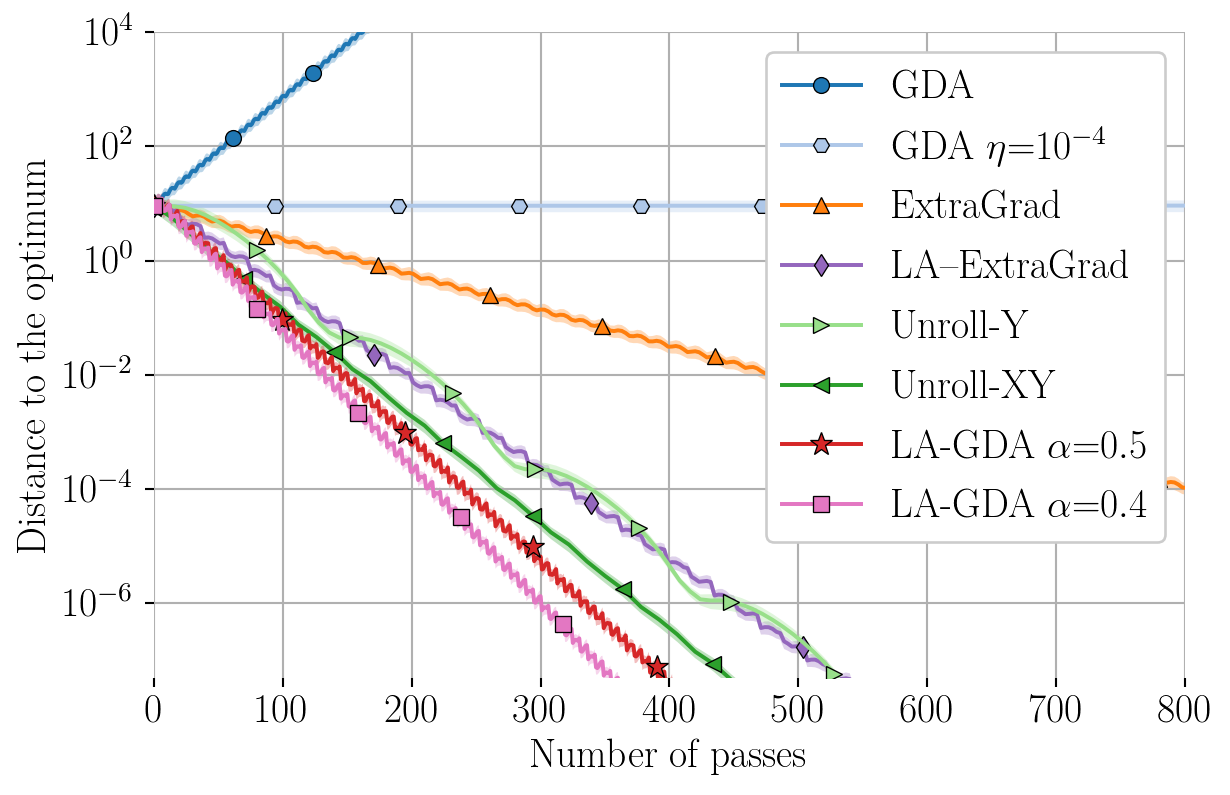

In [4]:
plt.rcParams['text.latex.preamble'] = [r"\usepackage{lmodern}"]
rcParams['figure.figsize'] = 7, 4.5
rcParams['text.usetex'] = True
rcParams['figure.dpi'] = 190
rcParams['font.family'] = 'lmodern'
rcParams['font.size'] = '15'
rcParams['text.latex.unicode'] = True
# -----------------------------------------------------------------------------
plot_avg = False
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

t_extra = 3. * np.array(range(n_pass // 3))
t_grad = np.array(range(n_pass))
t_ur_xy = (2. + 2 * ur_k) * np.array(range(n_pass // (ur_k * 2 + 2)))
t_ur_y = (2. + 1 * ur_k) * np.array(range(n_pass // (ur_k * 1 + 2)))
plt.xlim([0, n_pass])
plt.ylim([.00000005, 10000])
markers=['o','v','^','<','>','8','s','d','h','H','+','x','X','D','d','|','_']
markevery=0.1
markersize=6

batch_gd_mean, batch_gd_sup, batch_gd_inf = av_std(batch_gd)
plt.semilogy(t_grad, batch_gd_mean, label="GDA", color=colors20[0], 
             marker=markers[0], markevery=markevery, markersize=markersize,
             markeredgecolor="black", markeredgewidth=.5)           
plt.fill_between(t_grad, batch_gd_inf, batch_gd_sup, facecolor=colors20[0], alpha=.3)
if plot_avg:
    batch_gd_avg_mean, batch_gd_avg_sup, batch_gd_avg_inf = av_std(batch_gd_avg)
    plt.semilogy(t_grad, batch_gd_avg_mean, label="AVG-Grad", color=colors20[1])
    plt.fill_between(t_grad, batch_gd_avg_inf, batch_gd_avg_sup, facecolor=colors20[1], alpha=.3)

bgr_small_mean, bgr_small_sup, bgr_small_inf = av_std(bgd_small_eta)
plt.semilogy(t_grad, bgr_small_mean, label=r"GDA $\eta{=}10^{-4}$", 
             color=colors20[1], 
             marker=markers[9], markevery=markevery, markersize=markersize,
             markeredgecolor="black", markeredgewidth=.5)
plt.fill_between(t_grad, bgr_small_inf, bgr_small_sup, facecolor=colors20[1], alpha=.3)
if plot_avg:
    batch_gd_avg_mean, batch_gd_avg_sup, batch_gd_avg_inf = av_std(batch_gd_avg)
    plt.semilogy(t_grad, batch_gd_avg_mean, label="AVG-Grad", color=colors20[1])
    plt.fill_between(t_grad, batch_gd_avg_inf, batch_gd_avg_sup, facecolor=colors20[1], alpha=.3)

extra_gd_mean, extra_gd_sup, extra_gd_inf = av_std(extra_gd)
plt.semilogy(t_extra, extra_gd_mean, label="ExtraGrad", color=colors20[2], 
             marker=markers[2], markevery=markevery, markersize=markersize,
             markeredgecolor="black", markeredgewidth=.5)
plt.fill_between(t_extra, extra_gd_inf, extra_gd_sup, facecolor=colors20[2], alpha=.3)
if plot_avg:
    extra_gd_avg_mean, extra_gd_avg_sup, extra_gd_avg_inf = av_std(extra_gd_avg)
    plt.semilogy(t_extra, extra_gd_avg_mean, label="AVG-ExtraGrad", color=colors20[3])
    plt.fill_between(t_extra, extra_gd_avg_inf, extra_gd_avg_sup, facecolor=colors20[3], alpha=.3)

la_ex_mean, la_ex_sup, la_ex_inf = av_std(la_ex)
plt.semilogy(t_extra, la_ex_mean, label="LA--ExtraGrad", color=colors20[8], 
             marker=markers[7], markevery=markevery*2.5, markersize=markersize,
             markeredgecolor="black", markeredgewidth=.5)
plt.fill_between(t_extra, la_ex_inf, la_ex_sup, facecolor=colors20[8], alpha=.3)
if plot_avg:
    la_ex_avg_mean, la_ex_avg_sup, la_ex_avg_inf = av_std(la_ex_avg)
    plt.semilogy(t_extra, la_ex_avg_mean, label="AVG-LA-ExtraGrad", color=colors20[9])
    plt.fill_between(t_extra, la_ex_avg_inf, la_ex_avg_sup, facecolor=colors20[9], alpha=.3)

ur_y_mean, ur_y_sup, ur_y_inf = av_std(ur_y)
plt.semilogy(t_ur_y, ur_y_mean, label="Unroll-Y", color=colors20[5], 
             marker=markers[4], markevery=markevery, markersize=markersize,
             markeredgecolor="black", markeredgewidth=.5)
plt.fill_between(t_ur_y, ur_y_inf, ur_y_sup, facecolor=colors20[5], alpha=.3)
if plot_avg:
    ur_y_avg_mean, ur_y_avg_sup, ur_y_avg_inf = av_std(ur_y_avg)
    plt.semilogy(t_ur_y, ur_y_avg_mean, label="AVG-Unroll-Y", color=colors20[5])
    plt.fill_between(t_ur_y, ur_y_avg_inf, ur_y_avg_sup, facecolor=colors20[5], alpha=.3)

ur_xy_mean, ur_xy_sup, ur_xy_inf = av_std(ur_xy)
plt.semilogy(t_ur_xy, ur_xy_mean, label="Unroll-XY", color=colors20[4], 
             marker=markers[3], markevery=markevery, markersize=markersize,
             markeredgecolor="black", markeredgewidth=.5)
plt.fill_between(t_ur_xy, ur_xy_inf, ur_xy_sup, facecolor=colors20[4], alpha=.3)
if plot_avg:
    ur_xy_avg_mean, ur_xy_avg_sup, ur_xy_avg_inf = av_std(ur_xy_avg)
    plt.semilogy(t_ur_xy, ur_xy_avg_mean, label="AVG-Unroll-XY", color=colors20[5])
    plt.fill_between(t_ur_xy, ur_xy_avg_inf, ur_xy_avg_sup, facecolor=colors20[5], alpha=.3)

la_gd_mean, la_gd_sup, la_gd_inf = av_std(la_gd)
plt.semilogy(t_grad, la_gd_mean, label=r"LA-GDA $\displaystyle \alpha{=}0.5$", color=colors20[6], 
             marker='*', markevery=markevery*3, markersize=markersize*1.5,
             markeredgecolor="black", markeredgewidth=.5)
plt.fill_between(t_grad, la_gd_inf, la_gd_sup, facecolor=colors20[6], alpha=.3)
if plot_avg:
    la_gd_avg_mean, la_gd_avg_sup, la_gd_avg_inf = av_std(la_gd_avg)
    plt.semilogy(t_grad, la_gd_avg_mean, label="AVG-LA", color=colors20[7])
    plt.fill_between(t_grad, la_gd_avg_inf, la_gd_avg_sup, facecolor=colors20[7], alpha=.3)

laB_gd_mean, laB_gd_sup, laB_gd_inf = av_std(laB_gd)
plt.semilogy(t_grad, laB_gd_mean, label=r"LA-GDA $\displaystyle \alpha{=}0.4$", 
             color=colors20[12], 
             marker=markers[6], markevery=markevery*2.5, markersize=markersize,
             markeredgecolor="black", markeredgewidth=.5)
plt.fill_between(t_grad, laB_gd_inf, laB_gd_sup, facecolor=colors20[12], alpha=.3)
if plot_avg:
    laB_gd_avg_mean, laB_gd_avg_sup, laB_gd_avg_inf = av_std(laB_gd_avg)
    plt.semilogy(t_grad, laB_gd_avg_mean, label="AVG-LA {}".format(la_beta), color=colors20[13])
    plt.fill_between(t_grad, laB_gd_avg_inf, laB_gd_avg_sup, facecolor=colors20[13], alpha=.3)

plt.xlabel('Number of passes')
plt.ylabel('Distance to the optimum')
plt.grid()
plt.legend(fancybox=True, framealpha=1,  ncol=1, loc='upper right')
plt.savefig('bilinear_obj_lr{}_batch.pdf'.format(gamma), bbox_inches='tight')
print('Figure bilinear_obj_lr{}_batch.pdf saved'.format(gamma))
plt.show()